## Importing Libraries

In [1]:
import zipfile
import pandas as pd
import random
import seaborn as sns
import numpy as np
import os
import PIL
import pickle
from PIL import *
import cv2
import glob
from skimage import io
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import Model  
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import DenseNet121 # 2017 architecture
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.layers import *
from tensorflow.keras import Model 
from tensorflow.keras.models import load_model
from tensorflow import keras 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from prettytable import PrettyTable
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from pathlib import Path
import cv2 as cv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
%matplotlib inline


## References

**Res-U-Net Explanation**
https://www.kaggle.com/ekhtiar/resunet-a-baseline-on-tensorflow#Loss-Functions
<br>
https://towardsdatascience.com/introduction-to-u-net-and-res-net-for-image-segmentation-9afcb432ee2f

## Loading Dataset and Exploratory Data Analysis

In [2]:
brain_df = pd.read_csv('data_mask.csv')

In [3]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [4]:
brain_df.isnull().sum()

patient_id    0
image_path    0
mask_path     0
mask          0
dtype: int64

In [5]:
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [6]:
patient_id_dict = set()

In [7]:
for x in brain_df.patient_id:
    patient_id_dict.add('_'.join((str(x).split('_')[:-1])))

In [8]:
len(patient_id_dict)

110

In [9]:
brain_df.shape

(3929, 4)

In [10]:
brain_df['mask_path'][0]

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif'

In [11]:
df_detail = pd.read_csv('data_detailed.csv')

In [12]:
df_detail.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [13]:
print("Number of patients:", df_detail.Patient.nunique())

Number of patients: 110


In [14]:
df_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [15]:
df_detail.columns

Index(['Patient', 'RNASeqCluster', 'MethylationCluster', 'miRNACluster',
       'CNCluster', 'RPPACluster', 'OncosignCluster', 'COCCluster',
       'histological_type', 'neoplasm_histologic_grade', 'tumor_tissue_site',
       'laterality', 'tumor_location', 'gender', 'age_at_initial_pathologic',
       'race', 'ethnicity', 'death01'],
      dtype='object')

<AxesSubplot:>

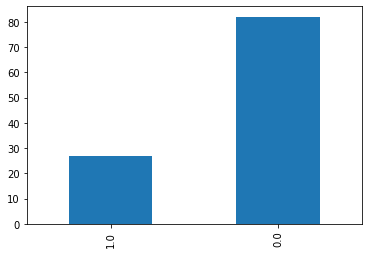

In [16]:
df_detail.death01.value_counts().sort_values().plot(kind = 'bar')

<AxesSubplot:>

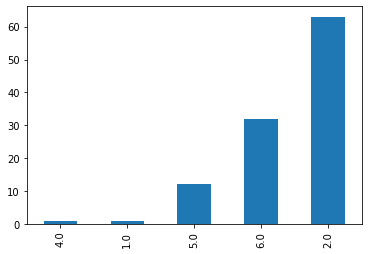

In [17]:
df_detail.tumor_location.value_counts().sort_values().plot(kind = 'bar')

<AxesSubplot:>

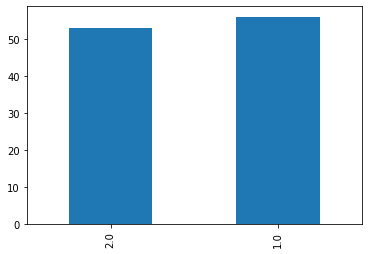

In [18]:
df_detail.gender.value_counts().sort_values().plot(kind = 'bar')

### MASK
- **What Is Mask?**
    - The goal of image segmentation is to understand image at the pixel level. It associates each pixel with a certian class. The output produced by image segementation model is called **MASK** of the image.
- Mask can be represented by associating pixel values with their coordinates for example it we have a black image of shape (2,2) this can be represented as:
[[0,0],
[0,0]]
- If our output mask is as follows:
[[255,0],
[0,255]]

- To represent this mask we have to first flatten the image into a 1-D array. this would result in something like [255,0,0,255] for mask . then we can use the index to create the mask. finally we would have something like [1,0,0,1] as our mask.

In [19]:
brain_df.mask_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [20]:
brain_df['mask'].unique()

array([0, 1], dtype=int64)

In [21]:
brain_df['mask'].unique()

array([0, 1], dtype=int64)

In [21]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [22]:
brain_df.dtypes

patient_id    object
image_path    object
mask_path     object
mask           int64
dtype: object

In [23]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [24]:
brain_df.shape, df_detail.shape

((3929, 4), (110, 18))

In [25]:
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [26]:
df_detail.Patient.nunique(), brain_df.patient_id.nunique()

(110, 110)

In [27]:
# fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
# fig.update_traces(marker_color = 'rgb(0,232, 0)', marker_line_color = 'rgb(0,0,0)',
#                   marker_line_width = 7, opacity = 0.6)
# fig.show()

In [28]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [29]:
p = Path('./')

In [30]:
folders = list(p.glob('./*'))
folders

[WindowsPath('.git'),
 WindowsPath('.ipynb_checkpoints'),
 WindowsPath('classifier-resnet-model.json'),
 WindowsPath('classifier-resnet-weights.hdf5'),
 WindowsPath('classifier-resnet-weights_fine_tuning_16b_345_2.hdf5'),
 WindowsPath('classifier-vgg16-model.json'),
 WindowsPath('classifier-vgg16-three-block-model.json'),
 WindowsPath('classifier-vgg16-transfer-learning-model.json'),
 WindowsPath('classifier-vgg16-weights.hdf5'),
 WindowsPath('data_detailed.csv'),
 WindowsPath('data_mask.csv'),
 WindowsPath('data_paths.csv'),
 WindowsPath('Detecting Brain Tumor Using MRI Scan.ipynb'),
 WindowsPath('model_fine_tuning_16b_345_2.json'),
 WindowsPath('model_save'),
 WindowsPath('README.md'),
 WindowsPath('res-unet-model1.json'),
 WindowsPath('res-unet-model2.json'),
 WindowsPath('res-unet-weights1.hdf5'),
 WindowsPath('res-unet-weights2.hdf5'),
 WindowsPath('resnet-50-MRI.json'),
 WindowsPath('ResUNet-model.json'),
 WindowsPath('TCGA_CS_4941_19960909'),
 WindowsPath('TCGA_CS_4942_19970222'

In [31]:
for x in folders:
    currentFolder = list(x.glob('./**')) # folders
    for y in currentFolder:
        files = list(y.glob('./*'))
        print('FOLDER NAME:'," ", y)
        print(files)
        print()
        
    print()

FOLDER NAME:   .git
[WindowsPath('.git/config'), WindowsPath('.git/description'), WindowsPath('.git/HEAD'), WindowsPath('.git/hooks'), WindowsPath('.git/index'), WindowsPath('.git/info'), WindowsPath('.git/logs'), WindowsPath('.git/objects'), WindowsPath('.git/packed-refs'), WindowsPath('.git/refs')]

FOLDER NAME:   .git\hooks
[WindowsPath('.git/hooks/applypatch-msg.sample'), WindowsPath('.git/hooks/commit-msg.sample'), WindowsPath('.git/hooks/fsmonitor-watchman.sample'), WindowsPath('.git/hooks/post-update.sample'), WindowsPath('.git/hooks/pre-applypatch.sample'), WindowsPath('.git/hooks/pre-commit.sample'), WindowsPath('.git/hooks/pre-merge-commit.sample'), WindowsPath('.git/hooks/pre-push.sample'), WindowsPath('.git/hooks/pre-rebase.sample'), WindowsPath('.git/hooks/pre-receive.sample'), WindowsPath('.git/hooks/prepare-commit-msg.sample'), WindowsPath('.git/hooks/push-to-checkout.sample'), WindowsPath('.git/hooks/update.sample')]

FOLDER NAME:   .git\info
[WindowsPath('.git/info/exc

FOLDER NAME:   TCGA_CS_5396_20010302
[WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_10.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_10_mask.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_11.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_11_mask.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_12.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_12_mask.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_13.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_13_mask.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_14.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_14_mask.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_15.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_15_mask.tif'), WindowsPath('TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_16.ti

FOLDER NAME:   TCGA_CS_6668_20011025
[WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_1.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_10.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_10_mask.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_11.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_11_mask.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_12.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_12_mask.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_13.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_13_mask.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_14.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_14_mask.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_15.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_15_mask.tif'), WindowsPath('TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_16.ti

FOLDER NAME:   TCGA_DU_5852_19950709
[WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_10.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_10_mask.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_11.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_11_mask.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_12.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_12_mask.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_13.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_13_mask.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_14.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_14_mask.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_15.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_15_mask.tif'), WindowsPath('TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_16.ti

FOLDER NAME:   TCGA_DU_5872_19950223
[WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_1.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_10.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_10_mask.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_11.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_11_mask.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_12.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_12_mask.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_13.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_13_mask.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_14.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_14_mask.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_15.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_15_mask.tif'), WindowsPath('TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_16.ti

FOLDER NAME:   TCGA_DU_7008_19830723
[WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_1.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_10.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_10_mask.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_11.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_11_mask.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_12.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_12_mask.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_13.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_13_mask.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_14.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_14_mask.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_15.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_15_mask.tif'), WindowsPath('TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_16.ti

FOLDER NAME:   TCGA_DU_7304_19930325
[WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_1.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_10.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_10_mask.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_11.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_11_mask.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_12.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_12_mask.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_13.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_13_mask.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_14.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_14_mask.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_15.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_15_mask.tif'), WindowsPath('TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_16.ti

FOLDER NAME:   TCGA_DU_A5TT_19980318
[WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_1.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_10.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_10_mask.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_11.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_11_mask.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_12.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_12_mask.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_13.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_13_mask.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_14.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_14_mask.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_15.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_15_mask.tif'), WindowsPath('TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_16.ti

FOLDER NAME:   TCGA_FG_7637_20000922
[WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_1.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_10.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_10_mask.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_11.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_11_mask.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_12.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_12_mask.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_13.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_13_mask.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_14.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_14_mask.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_15.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_15_mask.tif'), WindowsPath('TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_16.ti

FOLDER NAME:   TCGA_HT_7602_19951103
[WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_1.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_10.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_10_mask.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_11.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_11_mask.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_12.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_12_mask.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_13.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_13_mask.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_14.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_14_mask.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_15.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_15_mask.tif'), WindowsPath('TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_16.ti

FOLDER NAME:   TCGA_HT_7879_19981009
[WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_1.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_10.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_10_mask.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_11.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_11_mask.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_12.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_12_mask.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_13.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_13_mask.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_14.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_14_mask.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_15.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_15_mask.tif'), WindowsPath('TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_16.ti

FOLDER NAME:   TCGA_HT_A61A_20000127
[WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_1.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_10.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_10_mask.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_11.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_11_mask.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_12.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_12_mask.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_13.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_13_mask.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_14.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_14_mask.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_15.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_15_mask.tif'), WindowsPath('TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_16.ti

In [32]:
glob.glob(brain_df.mask_path[623])

['TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_6_mask.tif']

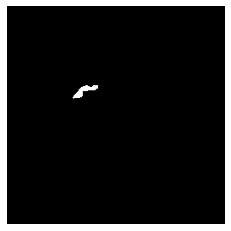

In [33]:
# im_plt = plt.imread(brain_df.mask_path[623])
im_cv = cv.imread(brain_df.mask_path[623])[:, :, ::-1] #OpenCV users BGR instead of RGB
plt.axis("off")
# plt.imshow(im_plt)
plt.imshow(im_cv) # works
plt.show()

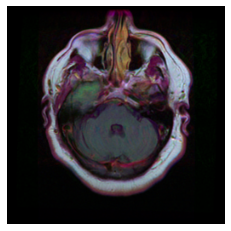

In [34]:
plt.imshow(cv2.imread(brain_df.image_path[623]))
plt.axis("off")
plt.show()

In [35]:
print(im_cv)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


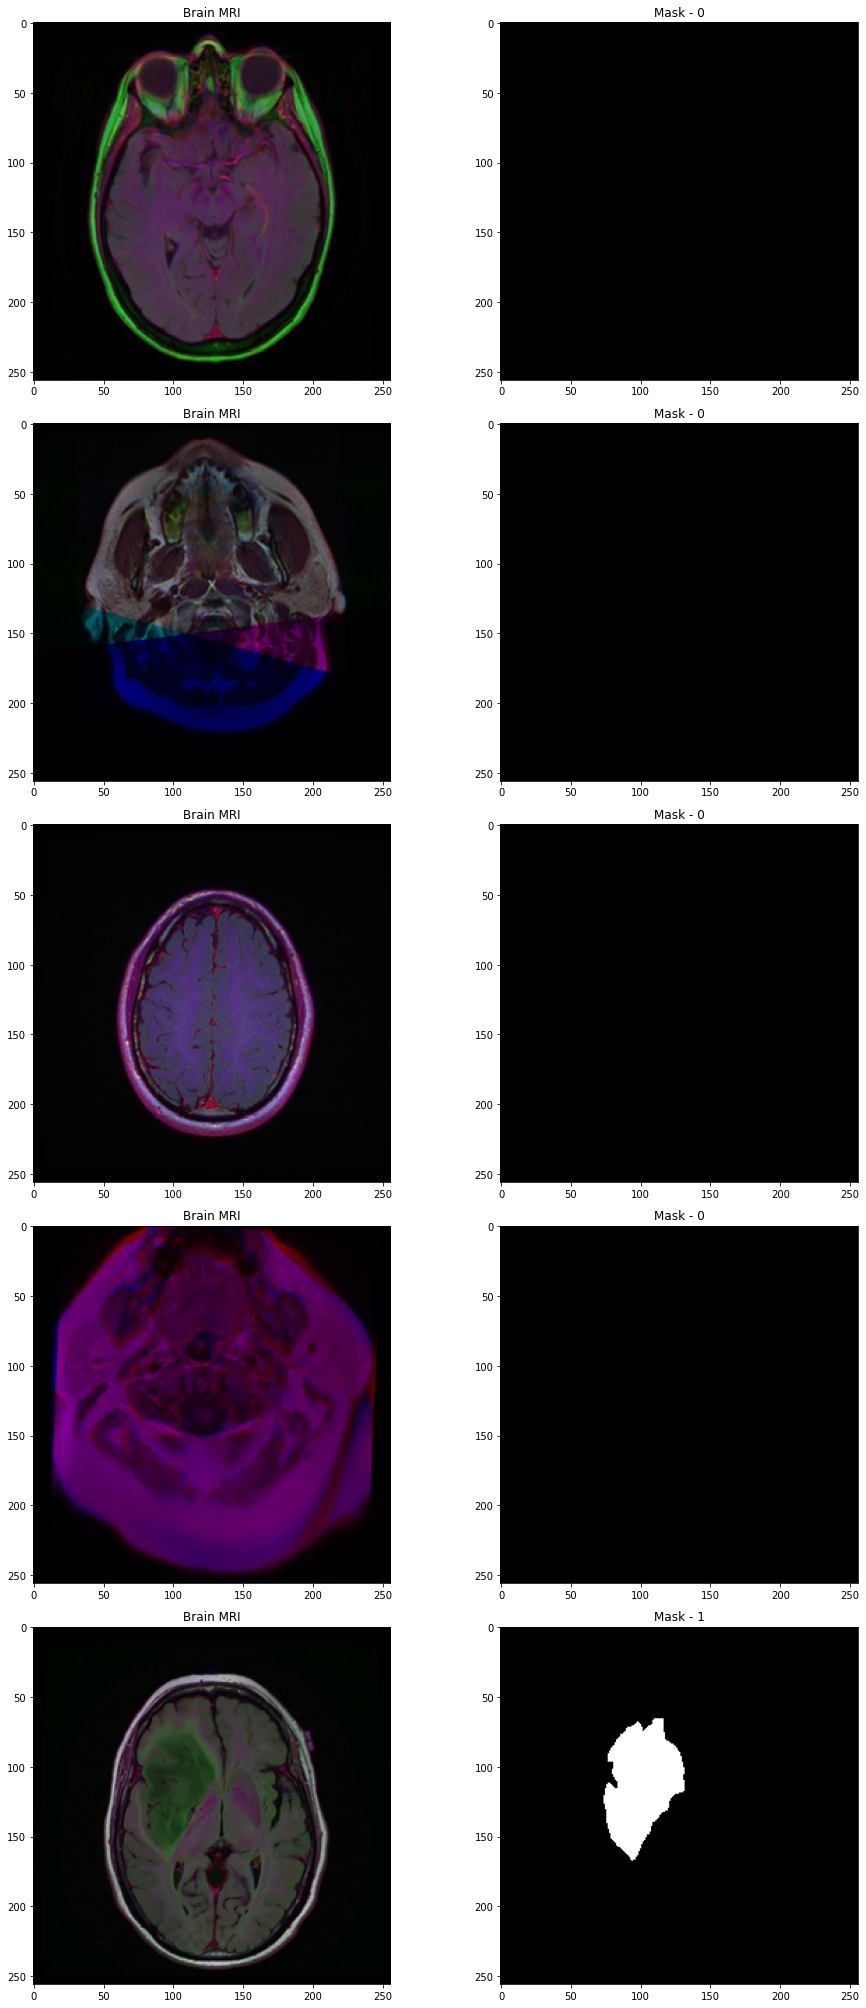

In [36]:
fig, axs = plt.subplots(5,2, figsize=(14,28))
count = 0
for x in range(5):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("Brain MRI") 
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

In [37]:
brain_df.image_path[0]

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif'

In [38]:
# print(io.imread(brain_df.image_path[0]))

In [39]:
def display_mri_mask(df:pd.DataFrame, no_images = 12):
    count = 0
    fig, axs = plt.subplots(12, 3, figsize = (20, 50))  # default 12 rows and 3 columns each for MRI, MASK and MRI with MASK
    for i in range(len(df)):
        if df['mask'][i] == 1 and count < no_images:

            # Print MRIs without mask
            img = io.imread(df.image_path[i]) # read image from path brain_df.image_path[i] and store its numerical/matrix representation into variable img 
            axs[count][0].title.set_text('Brain MRI') # Add Title to image
            axs[count][0].imshow(img) # Display Image

            mask = io.imread(df.mask_path[i])  # same for mask
            axs[count][1].title.set_text('Mask') # add title
            axs[count][1].imshow(mask, cmap = 'gray') # display


            img[mask == 255] = (255, 0, 0) # highlighting tumor
            axs[count][2].title.set_text('MRI with Mask')
            axs[count][2].imshow(img)
            count+=1
    fig.tight_layout()       

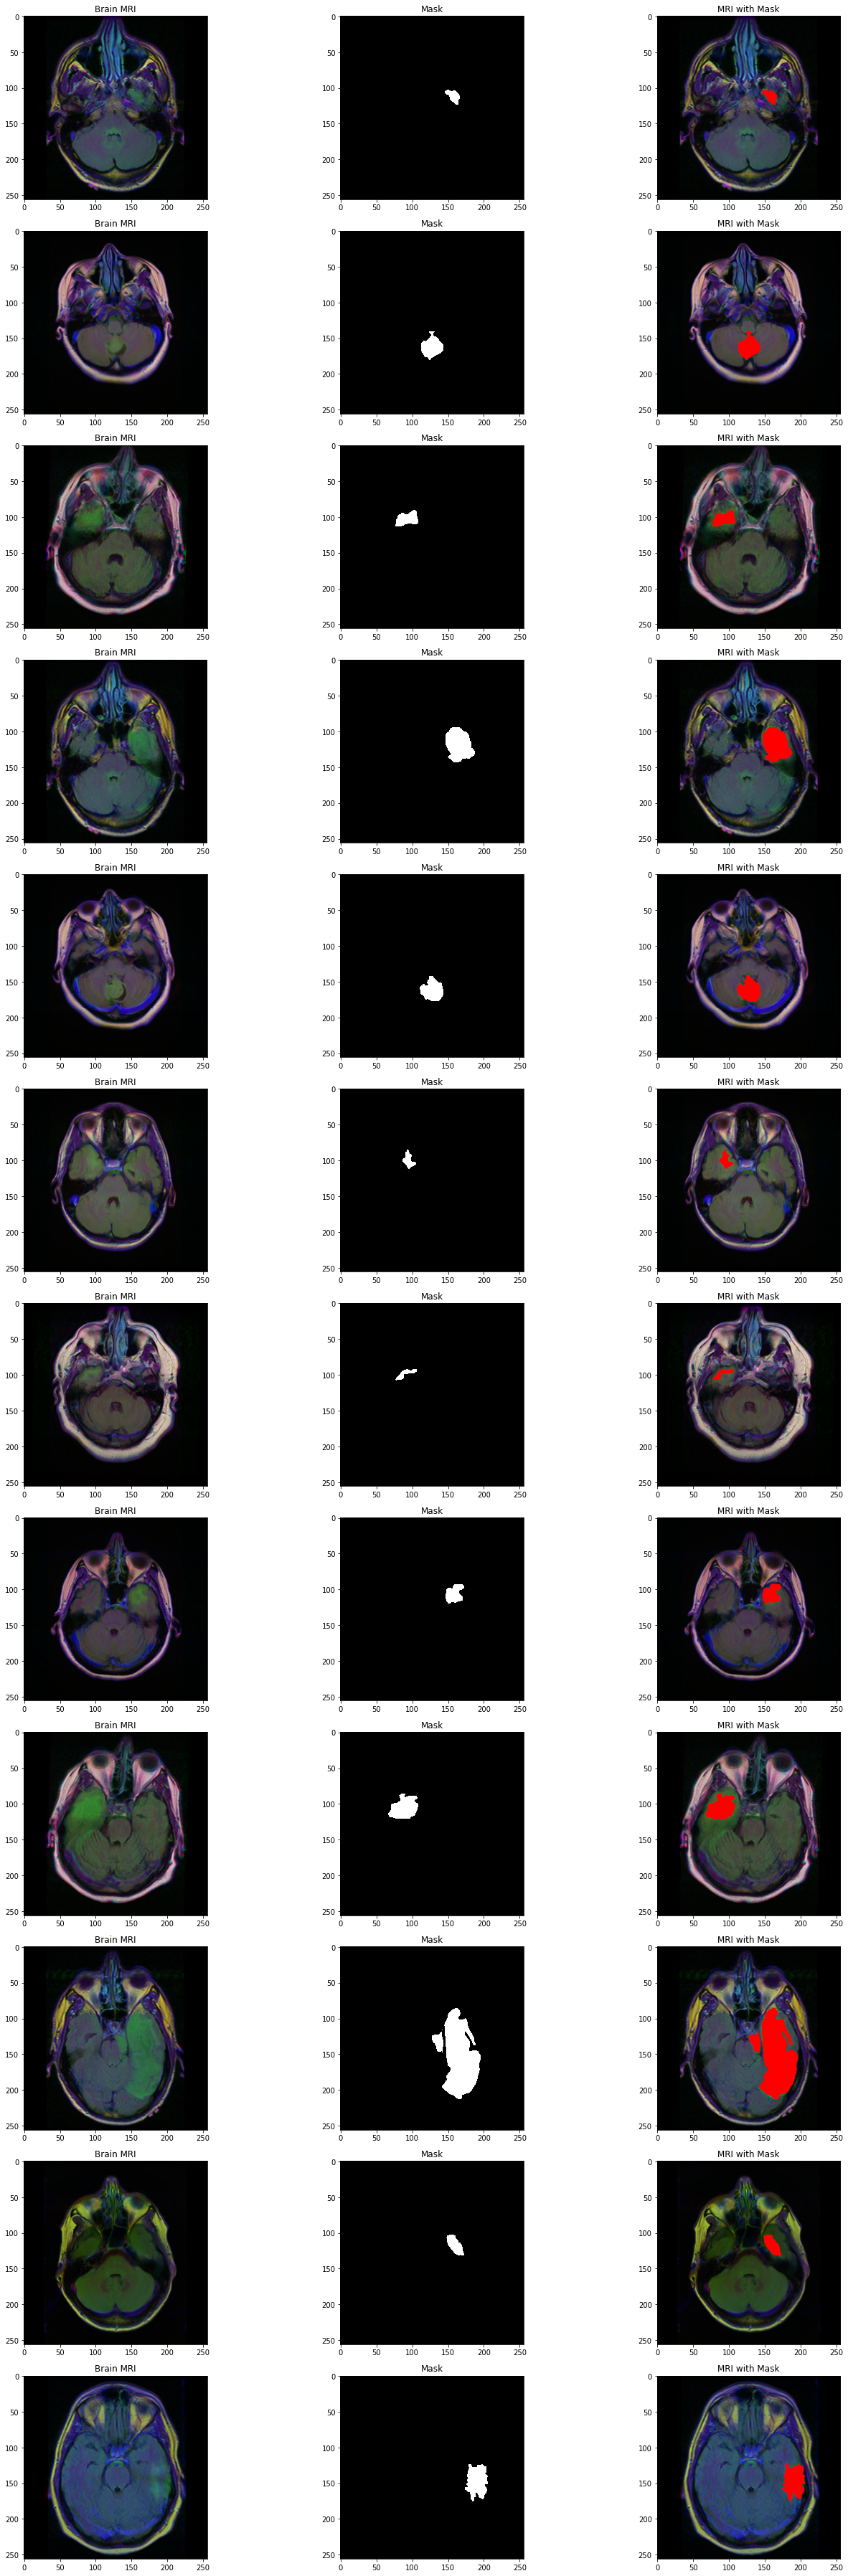

In [40]:
display_mri_mask(brain_df)

In [41]:
img = io.imread(brain_df.image_path[0])
type(img), len(img)

(numpy.ndarray, 256)

## Tumor Classification

In [153]:
brain_df_training = brain_df.drop(columns=['patient_id'])
brain_df_training.shape

(3929, 3)

In [154]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if we comment out the this code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_training['mask'] = brain_df_training['mask'].apply(lambda x: str(x))

In [155]:
brain_df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [156]:
train, test = train_test_split(brain_df_training, test_size = 0.23)

## Data Prepration
- Before we use our dataset for training we do data/image augmentation
- More data can help our model to give better performance
- Image Augmentation is techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data
- To do this I am using keras

###### https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

In [157]:
def train_val_test_data_gen(TRAIN:pd.DataFrame,TRAIN_PATH:str, VAL:pd.DataFrame, VAL_PATH:str, TEST:pd.DataFrame, 
                            TEXT_PATH:str, CLASS_MODE: str, BATCH_SIZE=16, IMAGE_SHAPE = (256,256)):
    # Create a data generator which scales the data in range  [0, 1] and makes validation split of 30%
    datagen = ImageDataGenerator(
                                 rescale=1./255., # normalize
                                 validation_split = 0.30)
    
    train_generator=datagen.flow_from_dataframe(
                                                    dataframe=TRAIN,
                                                    directory= TRAIN_PATH,
                                                    x_col='image_path',
                                                    y_col='mask',
                                                    subset="training",
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode=CLASS_MODE,
                                                    target_size=IMAGE_SHAPE)


    val_generator=datagen.flow_from_dataframe(
                                                    dataframe=VAL,
                                                    directory= VAL_PATH,
                                                    x_col='image_path',
                                                    y_col='mask',
                                                    subset="validation",
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode=CLASS_MODE,
                                                    target_size=IMAGE_SHAPE)

    # Create a data generator for test images
    test_datagen=ImageDataGenerator(rescale=1./255.)

    test_generator=test_datagen.flow_from_dataframe(
                                                    dataframe=TEST,
                                                    directory= TEXT_PATH,
                                                    x_col='image_path',
                                                    y_col='mask',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    class_mode=CLASS_MODE,
                                                    target_size=IMAGE_SHAPE)

    return train_generator, val_generator, test_generator

In [158]:
TRAIN = train
VAL = train
TEST = test
TRAIN_PATH = TEST_PATH = VAL_PATH = './'
BATCH_SIZE = 16
CLASS_MODE = "categorical"
train_generator, valid_generator, test_generator = train_val_test_data_gen(TRAIN, TRAIN_PATH, VAL, VAL_PATH, TEST, TEST_PATH, CLASS_MODE, BATCH_SIZE)

Found 2118 validated image filenames belonging to 2 classes.
Found 907 validated image filenames belonging to 2 classes.
Found 904 validated image filenames belonging to 2 classes.


## ResNet 50 Transfer Learning

## Transfer Learning
- Transfer learning is a research problem in Deep learning (DL) that focuses on storing knowledge gained while training one model and applying it to another model here we are using ResNet50.
- How it works?
    All we need to do is delete or remove the last layer in the network and replace it with a new layer. Also, the weights associated with the last layer are re-initialized and the model is trained using the images instead of deleting/removing last layer we can also add several layers.
- There are various other approaches to implement it, that can be used depending upon the type of problem.
- Here I will freeze the existing layers while training the model with the MRI data-set, meaning that the weights in these layers are not changed. During the training process, only the randomly initialized weights associated with newly added layers are changed until they converge. This process is also known as **fine-tuning**
- Fine-tuning is one approach to transfer learning where you change the model output to fit the new task and train only the output model. In Transfer Learning or Domain Adaptation, we train the model with a dataset.

#### Fine Tuning
- Here I will freeze weights of ResNet50 model.
- This approach is better when the data available for training is less and the task for which the existing model is trained is similar to the task we are interested in.

#### What does Freezing a Layer mean?
- Freezing a layer prevents its weights from being modified here the base model(trained on imagenet dataset)is frozen.
- We will only train addition layers that I will add in the end of basemodel, this will make faster training


#### Adding Classification Layer
- Once basemodel layers are freezed we can move ahead and add new layers for classification of MRIs
- https://learnopencv.com/number-of-parameters-and-tensor-sizes-in-convolutional-neural-network/#:~:text=In%20a%20CNN%2C%20each%20layer,of%20all%20weights%20and%20biases.&text=%3D%20Number%20of%20biases%20of%20the,used%20in%20the%20Conv%20Layer
- A dense layer also referred to as a fully connected layer is a layer that is used in the final stages of the neural network. This layer helps in changing the dimensionality of the output from the preceding layer so that the model can easily define the relationship between the values of the data in which the model is working.
- https://analyticsindiamag.com/a-complete-understanding-of-dense-layers-in-neural-networks/
- Choosing size of dense layer : https://stackoverflow.com/questions/36950394/how-to-decide-the-size-of-layers-in-keras-dense-method/53120987
- Choosing Activation function: https://stats.stackexchange.com/questions/218542/which-activation-function-for-output-layer
- Choosing activation function for output layer: https://stats.stackexchange.com/questions/218542/which-activation-function-for-output-layer#:~:text=Use%20simple%20sigmoid%20only%20if%20your%20output%20admits%20multiple%20%22true%22%20answers 

In [48]:
# Fine tuning ResNet50 Base model
def build_resnet50_model():
    # Get the ResNet50 base model transfer learning
    basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))
    for layer in basemodel.layers:
        layers.trainable = False
    # Add classification head to the basemodel
    head = basemodel.output
    head = AveragePooling2D(pool_size = (4,4))(head) # Apply averagePooling2D on headmodel
    head = Flatten(name= 'flatten')(head) # flatten it
    head = Dense(256, activation = "relu")(head) # relu to overcome gradient decent problem 
    head = Dropout(0.3)(head) # to prevent overfitting
    head = Dense(256, activation = "relu")(head)
    head = Dropout(0.3)(head)
    head = Dense(128, activation = "relu")(head)
    head = Dropout(0.3)(head)
    head = Dense(2, activation = 'softmax')(head) # "Softmax" Activation layer for classification
    model = Model(inputs = basemodel.input, outputs = head)
    return model

headmodel = Dense(2, activation = 'softmax')(headmodel)
Since the final layer outputs (2) probability for each classes, we use "categorical_crossentropy". 
https://stackoverflow.com/questions/45793856/binary-classification-with-softmax
categorical cross entropy loss: If we use categorical cross entropy loss function, then we provide the ground truth as an n-dimensional vector in which all entries are 0 except the entry corresponding to the class, which is 1 (one-hot-encoding).

Sparse categorical cross entropy loss: If we use sparse categorical cross entropy then we provide the ground truth as single integer unit only rather than as an n-dimensional vector. Here the integer represents the class of the data.

In [62]:
model_resnet = build_resnet50_model()

In [65]:
model_resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

- Since, we are using Softmax activation function in our output layer of the new model.
- Softmax gives probablity of each class, which sums up to be 1 or 100%
- for binary_crossentropy: sigmoid activation, scalar target
- for categorical_crossentropy: softmax activation, one-hot encoded target
- Optimizers : https://ruder.io/optimizing-gradient-descent/index.html#adam

In [66]:
# compilations of model
model_resnet.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics =['accuracy'])

- https://www.educative.io/edpresso/what-is-early-stopping
- Verbose in earlystopping take value of 0/1.
- If you put Verbose value as 1 in ModelCheckPoint callback, after every epoch you will get a statement like Model improved from error this to that or nor change in loss
- In EarlyStopping, whenever your training gets stopped due to not improving the model, a log says Stopped training bcoz your model did not improved

In [54]:
def lf_schedule(epoch,lr):
    if epoch%3 ==0:
        lr=lr - 0.05*lr #-->i.e. 0.95*lr (5% decay)
        print(f'New learning rate for epoch={epoch} is {lr}')
        return lr
    else:
        return lr

- https://rdrr.io/cran/kerasR/man/ReduceLROnPlateau.html
- https://keras.io/api/callbacks/model_checkpoint/

In [53]:
def make_callback_earlystop(MODEL_WEIGHT_NAME:str):
    
    # use early stopping to exit training if validation loss is not decreasing even after certain epochs
    callback1 = EarlyStopping( monitor="val_accuracy", patience=2, verbose=1, mode="auto", min_delta=0)
    # If validation accuracy at current epoch is less than previous epoch accuracy, decrease the learning rate by factor of 10%. 
    callback2 = ReduceLROnPlateau( monitor="val_accuracy", factor=0.1, patience=1, verbose=1, mode="auto")
    # For every 3rd epoch, decay learning rate by 5%
    callback3 = LearningRateScheduler( schedule=lf_schedule,verbose=1)
    # save the best model with least validation loss
    checkpointer = ModelCheckpoint(filepath=f"{MODEL_WEIGHT_NAME}.hdf5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="auto")
    return checkpointer, callback1, callback2, callback3


- train_generator.n = gives size of train dataset

In [82]:
checkpointer, callback1, callback2, callback3 = make_callback_earlystop("classifier-resnet-weights")

In [87]:
history = model_resnet.fit(train_generator, 
                    steps_per_epoch= train_generator.n // 64, 
                    epochs = 100, validation_data= valid_generator, validation_steps= valid_generator.n // 64, callbacks=[checkpointer, callback1, callback2, callback3])

In [88]:
# # save the model architecture to json file for future use
model_json = model_resnet.to_json()
with open("classifier-resnet-model.json","w") as json_file:
      json_file.write(model_json)

In [98]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('classifier-resnet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model_resnet = tf.keras.models.model_from_json(json_savedModel)
model_resnet.load_weights('classifier-resnet-weights.hdf5')
model_resnet.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [118]:
def model_prediction(model, MODEL_NAME:str, test_generator, BINARY = False):
    test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)
    
    # Obtain the predicted class from the model prediction
    
    # Obtain the predicted class from the model prediction
    predict = []

    if(BINARY == True):
        _,accuracy = model.evaluate_generator(generator=test_generator,steps=len(test_generator))
        print(MODEL_NAME,"accuracy:",np.round(accuracy*100,4),"%")
        test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)
        for i in test_predict:
            if i[0]>0.4:
                predict.append(1)
            else:
                predict.append(0)
        predict = np.asarray(predict)
        original = np.asarray(test['mask'])[:len(predict)]
        original = original.astype('int64', copy=False)
        predict = predict.astype('int64', copy=False)

        
   
    else:
        for i in test_predict:
            predict.append(str(np.argmax(i)))
        predict = np.asarray(predict)
        original = np.asarray(test['mask'])[:len(predict)]
            
    
    #since we have used test generator, it limited the images to len(predict), due to batch size
    
    accuracy = accuracy_score(original, predict)
    print()
    print(MODEL_NAME,"accuracy:",np.round(accuracy*100,4),"%")
    print()
    # plotting the confusion matrix
    cm = confusion_matrix(original, predict)
    plt.figure(figsize = (7,7))
    sns.heatmap(cm, annot=True)
    print()
    report = classification_report(original, predict, labels = [0,1])
    print((report))

In [88]:
model_prediction(model_resnet, "Resnet50 Model")

## Model #2: VGG16 Tranfer Learning

In [163]:
train, test = train_test_split(brain_df_training, test_size = 0.23)
TRAIN = train
VAL = train
TEST = test
TRAIN_PATH = TEST_PATH = VAL_PATH = './'
BATCH_SIZE = 16
CLASS_MODE = "binary"
IMAGE_SHAPE = (224,224)
train_generator, valid_generator, test_generator = train_val_test_data_gen(TRAIN, 
                                                                           TRAIN_PATH, 
                                                                           VAL, 
                                                                           VAL_PATH, 
                                                                           TEST, 
                                                                           TEST_PATH, 
                                                                           CLASS_MODE, 
                                                                           BATCH_SIZE,
                                                                           IMAGE_SHAPE)

Found 2118 validated image filenames belonging to 2 classes.
Found 907 validated image filenames belonging to 2 classes.
Found 904 validated image filenames belonging to 2 classes.


In [179]:
def model1_vgg16():
    base_model_1 = VGG16(weights="imagenet", include_top=False, input_tensor = Input(shape=(224, 224, 3)))
    for layer in base_model_1.layers:
        layers.trainable = False
    # Add classification head to the basemodel
    head = base_model_1.output
    head = Flatten()(head)
    head = Dense(units=128,activation='relu',kernel_initializer="he_uniform")(head)
    head = Dense(1, activation = 'sigmoid')(head)
    model_vgg = Model(inputs = base_model_1.input, outputs = head)
    return model_vgg

In [70]:
model_1_vgg_16 = model1_vgg16()
model_1_vgg_16.compile(optimizer='adam', loss = 'binary_crossentropy', metrics =['accuracy'])

In [71]:
checkpointer, callback1, callback2, callback3 = make_callback_earlystop("model_1_vgg_16_weights")

In [73]:
history_vgg = model_1_vgg_16.fit(train_generator, 
                    steps_per_epoch= train_generator.n // 16, 
                    epochs = 20, validation_data= valid_generator, 
                    validation_steps= valid_generator.n // 16, 
                    callbacks=[checkpointer, callback1, callback2, callback3])

New learning rate for epoch=0 is 0.0009025000152178108

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009025000152178108.
Epoch 1/20
4/4 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.5469 
Epoch 00001: val_accuracy improved from -inf to 0.68750, saving model to model_1_vgg_16_weights.hdf5
4/4 [==============================] - 45s 12s/step - loss: 0.6983 - accuracy: 0.5469 - val_loss: 0.6901 - val_accuracy: 0.6875 - lr: 9.0250e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009025000035762787.
Epoch 2/20
4/4 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.6406 
Epoch 00002: val_accuracy did not improve from 0.68750

Epoch 00002: ReduceLROnPlateau reducing learning rate to 9.025000035762788e-05.
4/4 [==============================] - 47s 12s/step - loss: 0.6911 - accuracy: 0.6406 - val_loss: 0.6726 - val_accuracy: 0.6875 - lr: 9.0250e-05

Epoch 00003: LearningRateScheduler setting learning rate to 9.0

https://stackoverflow.com/questions/56207651/why-doesnt-the-accuracy-when-training-vgg-16-change-much
- needs to be trained on more epochs which will require time and computation powers :)

In [74]:
# save the model architecture to json file for future use
model_json = model_1_vgg_16.to_json()
with open("classifier-vgg16-model1.json","w") as json_file:
      json_file.write(model_json)

In [161]:
with open('classifier-vgg16-model1.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model1_vgg16 = tf.keras.models.model_from_json(json_savedModel)
model1_vgg16.load_weights('model_1_vgg_16_weights.hdf5')
model1_vgg16.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ["accuracy"])

56/56 [==============================] - 156s 3s/step

VGG16 Model 1 accuracy: 35.4911 %


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       578
           1       0.35      1.00      0.52       318

    accuracy                           0.35       896
   macro avg       0.18      0.50      0.26       896
weighted avg       0.13      0.35      0.19       896



C:\Users\aryav\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aryav\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aryav\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


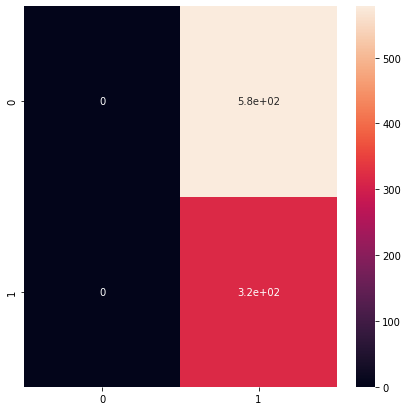

In [162]:
model_prediction(model1_vgg16, "VGG16 Model 1", test_generator, True)

In [169]:
train, test = train_test_split(brain_df_training, test_size = 0.23)
TRAIN = train
VAL = train
TEST = test
TRAIN_PATH = TEST_PATH = VAL_PATH = './'
BATCH_SIZE = 16
CLASS_MODE = "binary"
IMAGE_SHAPE = (224,224)
train_generator, valid_generator, test_generator = train_val_test_data_gen(TRAIN, 
                                                                           TRAIN_PATH, 
                                                                           VAL, 
                                                                           VAL_PATH, 
                                                                           TEST, 
                                                                           TEST_PATH, 
                                                                           CLASS_MODE, 
                                                                           BATCH_SIZE,
                                                                           IMAGE_SHAPE)

Found 2118 validated image filenames belonging to 2 classes.
Found 907 validated image filenames belonging to 2 classes.
Found 904 validated image filenames belonging to 2 classes.


In [111]:
def CNN_MODEL():
    model=Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=128,kernel_size=(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=128,activation="relu",kernel_initializer="he_uniform"))
    model.add(Dropout(0.5))
    model.add(Dense(units=1,activation="sigmoid"))
    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
    return model

In [110]:
checkpointer, callback1, callback2, callback3 = make_callback_earlystop("CNN_MODEL_weights")

In [621]:
model_cnn=CNN_MODEL()
history = model_cnn.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=train_generator,
                              validation_steps=len(valid_generator),
                              epochs=20,
                              callbacks=[callback1,callback2,callback3])

C:\Users\aryav\AppData\Local\Temp/ipykernel_1952/3082455685.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


New learning rate for epoch=0 is 0.0009500000451225787

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/20
133/133 [==============================] - 130s 975ms/step - loss: 0.6382 - accuracy: 0.7205 - val_loss: 0.4239 - val_accuracy: 0.7774 - lr: 9.5000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/20
133/133 [==============================] - 127s 951ms/step - loss: 0.4456 - accuracy: 0.7705 - val_loss: 0.4360 - val_accuracy: 0.8147 - lr: 9.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4181 - accuracy: 0.7823
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.500000160187483e-05.
133/133 [==============================] - 128s 962ms/step - loss: 0.4181 - accuracy: 0.7823 - val_loss: 0.3631 - val_accuracy: 0.8092 - lr: 9.5000e-05
New learning rate for epoch=3 is 9.0250

In [622]:
model.save_weights('CNN_MODEL_weights.hdf5')

In [623]:
model_json = model.to_json()
with open("CNN_MODEL.json","w") as json_file:
      json_file.write(model_json)

In [170]:
with open('CNN_MODEL.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('CNN_MODEL_weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ["accuracy"])

56/56 [==============================] - 13s 234ms/step

CNN Model accuracy: 87.3884 %


              precision    recall  f1-score   support

           0       0.96      0.84      0.90       574
           1       0.77      0.93      0.84       322

    accuracy                           0.87       896
   macro avg       0.86      0.89      0.87       896
weighted avg       0.89      0.87      0.88       896



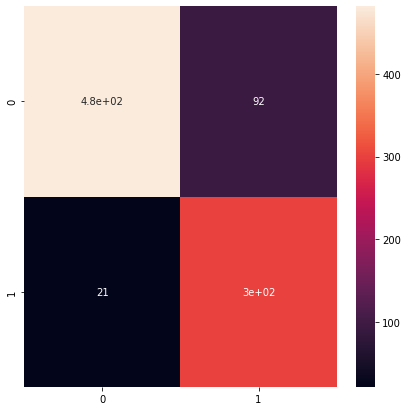

In [171]:
model_prediction(model, "CNN Model", test_generator,True)

## VGG Model #2

In [173]:
def VGG_MODEL_2():    
    model=VGG16(include_top=False,input_shape=(224,224,3))
    for layer in model.layers:
        layer.trainable=False
    flat = Flatten()(model.layers[-1].output)
    classifier = Dense(units=128,activation='relu',kernel_initializer="he_uniform")(flat)
    output = Dense(units=1,activation="sigmoid")(classifier)
    model = Model(inputs=model.inputs,outputs=output)
    model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
    return model

In [175]:
train, test = train_test_split(brain_df_training, test_size = 0.23)
TRAIN = train
VAL = train
TEST = test
TRAIN_PATH = TEST_PATH = VAL_PATH = './'
BATCH_SIZE = 16
CLASS_MODE = "binary"
IMAGE_SHAPE = (224,224)
train_generator, valid_generator, test_generator = train_val_test_data_gen(TRAIN, 
                                                                           TRAIN_PATH, 
                                                                           VAL, 
                                                                           VAL_PATH, 
                                                                           TEST, 
                                                                           TEST_PATH, 
                                                                           CLASS_MODE, 
                                                                           BATCH_SIZE,
                                                                           IMAGE_SHAPE)

Found 2118 validated image filenames belonging to 2 classes.
Found 907 validated image filenames belonging to 2 classes.
Found 904 validated image filenames belonging to 2 classes.


In [685]:
model=VGG_MODEL_2()
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator),
                              validation_data=train_generator,
                              validation_steps=len(valid_generator),
                              epochs=20,
                              callbacks=[callback1,callback2,callback3, callback4])

C:\Users\aryav\AppData\Local\Temp/ipykernel_1952/370076279.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


New learning rate for epoch=0 is 0.0009500000451225787

Epoch 00001: LearningRateScheduler setting learning rate to 0.0009500000451225787.
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.7479 - accuracy: 0.7573
Epoch 00001: val_accuracy improved from -inf to 0.81908, saving model to model_save\best_model.h5
133/133 [==============================] - 665s 5s/step - loss: 0.7479 - accuracy: 0.7573 - val_loss: 0.3729 - val_accuracy: 0.8191 - lr: 9.5000e-04

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8248
Epoch 00002: val_accuracy improved from 0.81908 to 0.85855, saving model to model_save\best_model.h5
133/133 [==============================] - 642s 5s/step - loss: 0.3613 - accuracy: 0.8248 - val_loss: 0.3092 - val_accuracy: 0.8586 - lr: 9.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009500000160187483.
Epoc

KeyboardInterrupt: 

In [686]:
model.save_weights('vgg16-model2-transfer-learning.hdf5')

In [687]:
model_json = model.to_json()
with open("classifier-vgg16-model2-transfer-learning.json","w") as json_file:
      json_file.write(model_json)

In [176]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('classifier-vgg16-model2-transfer-learning.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('vgg16-model2-transfer-learning.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics= ["accuracy"])

56/56 [==============================] - 185s 3s/step

VGG16 Model-2 accuracy: 87.6116 %


              precision    recall  f1-score   support

           0       0.96      0.85      0.90       585
           1       0.77      0.93      0.84       311

    accuracy                           0.88       896
   macro avg       0.86      0.89      0.87       896
weighted avg       0.89      0.88      0.88       896



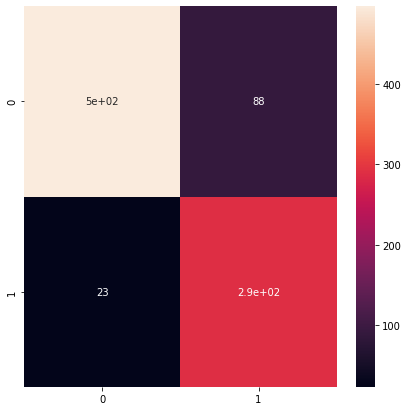

In [180]:
model_prediction(model, "VGG16 Model-2", test_generator,True)

## Testing New Models

In [184]:
# print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
# !nvidia-smi -L

### Segmentation Model To Localize Tumor

In [185]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [186]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
X_train

,patient_id,image_path,mask_path,mask
3713,TCGA_DU_8167_19970402,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_52...,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_52...,1
2372,TCGA_FG_A4MT_20020212,TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_22...,TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_22...,1
3678,TCGA_FG_6688_20020215,TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_50...,TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_50...,1
2399,TCGA_FG_A4MT_20020212,TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_23...,TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_23...,1
3681,TCGA_FG_6688_20020215,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_50...,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_50...,1
...,...,...,...,...
3474,TCGA_CS_6667_20011105,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_42...,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_42...,1
2851,TCGA_HT_7686_19950629,TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_29...,TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_29...,1
2143,TCGA_FG_6691_20020405,TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_20...,TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_20...,1
3218,TCGA_HT_8563_19981209,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_35...,TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_35...,1


In [187]:
#separate list for imageId, classId to pass into the generator
train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)
val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)
print(train_ids[0])
print(train_mask[0])
print(val_ids[0])
print(val_mask[0])

TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_52.tif
TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_52_mask.tif
TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_16.tif
TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_16_mask.tif


## Custom Datagenerator

In [188]:
#Utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator
#create image generators

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [189]:
def resblock(X, f):
  

  # make a copy of input
  X_copy = X

  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [190]:
# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge

In [191]:
input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


In [192]:
model_seg.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                           

### Loss function
- We need a custom loss function to train this ResUNet.So, we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

In [193]:
from utilities import focal_tversky, tversky_loss, tversky

In [201]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [202]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [203]:
history = model_seg.fit(training_generator, epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

TypeError: in user code:

    File "C:\Users\aryav\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\aryav\Desktop\BRAIN Image Segementation\Detecting-Brain-Tumor-Using-Deep-Learning\utilities.py", line 218, in focal_tversky  *
        pt_1 = tversky(y_true, y_pred)
    File "C:\Users\aryav\Desktop\BRAIN Image Segementation\Detecting-Brain-Tumor-Using-Deep-Learning\utilities.py", line 208, in tversky  *
        true_pos = K.sum(y_true_pos * y_pred_pos)

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int32 of argument 'x'.


In [171]:
# save the model architecture to json file for future use

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

C:\Users\aryav\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [199]:
from utilities import focal_tversky, tversky_loss, tversky

with open('res-unet-model2.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('res-unet-weights2.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [200]:
# Utilities file contains the code for custom loss function and custom data generator
from utilities import prediction
# making prediction
image_id, mask, has_mask = prediction(test, model, model_seg)

ValueError: in user code:

    File "C:\Users\aryav\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\aryav\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\aryav\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\aryav\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\aryav\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\aryav\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_19" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 256, 256, 3)


In [174]:
# creating a dataframe for the result
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

NameError: name 'image_id' is not defined

In [175]:
# Merge the dataframe containing predicted results with the original test data.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

NameError: name 'df_pred' is not defined

NameError: name 'df_pred' is not defined

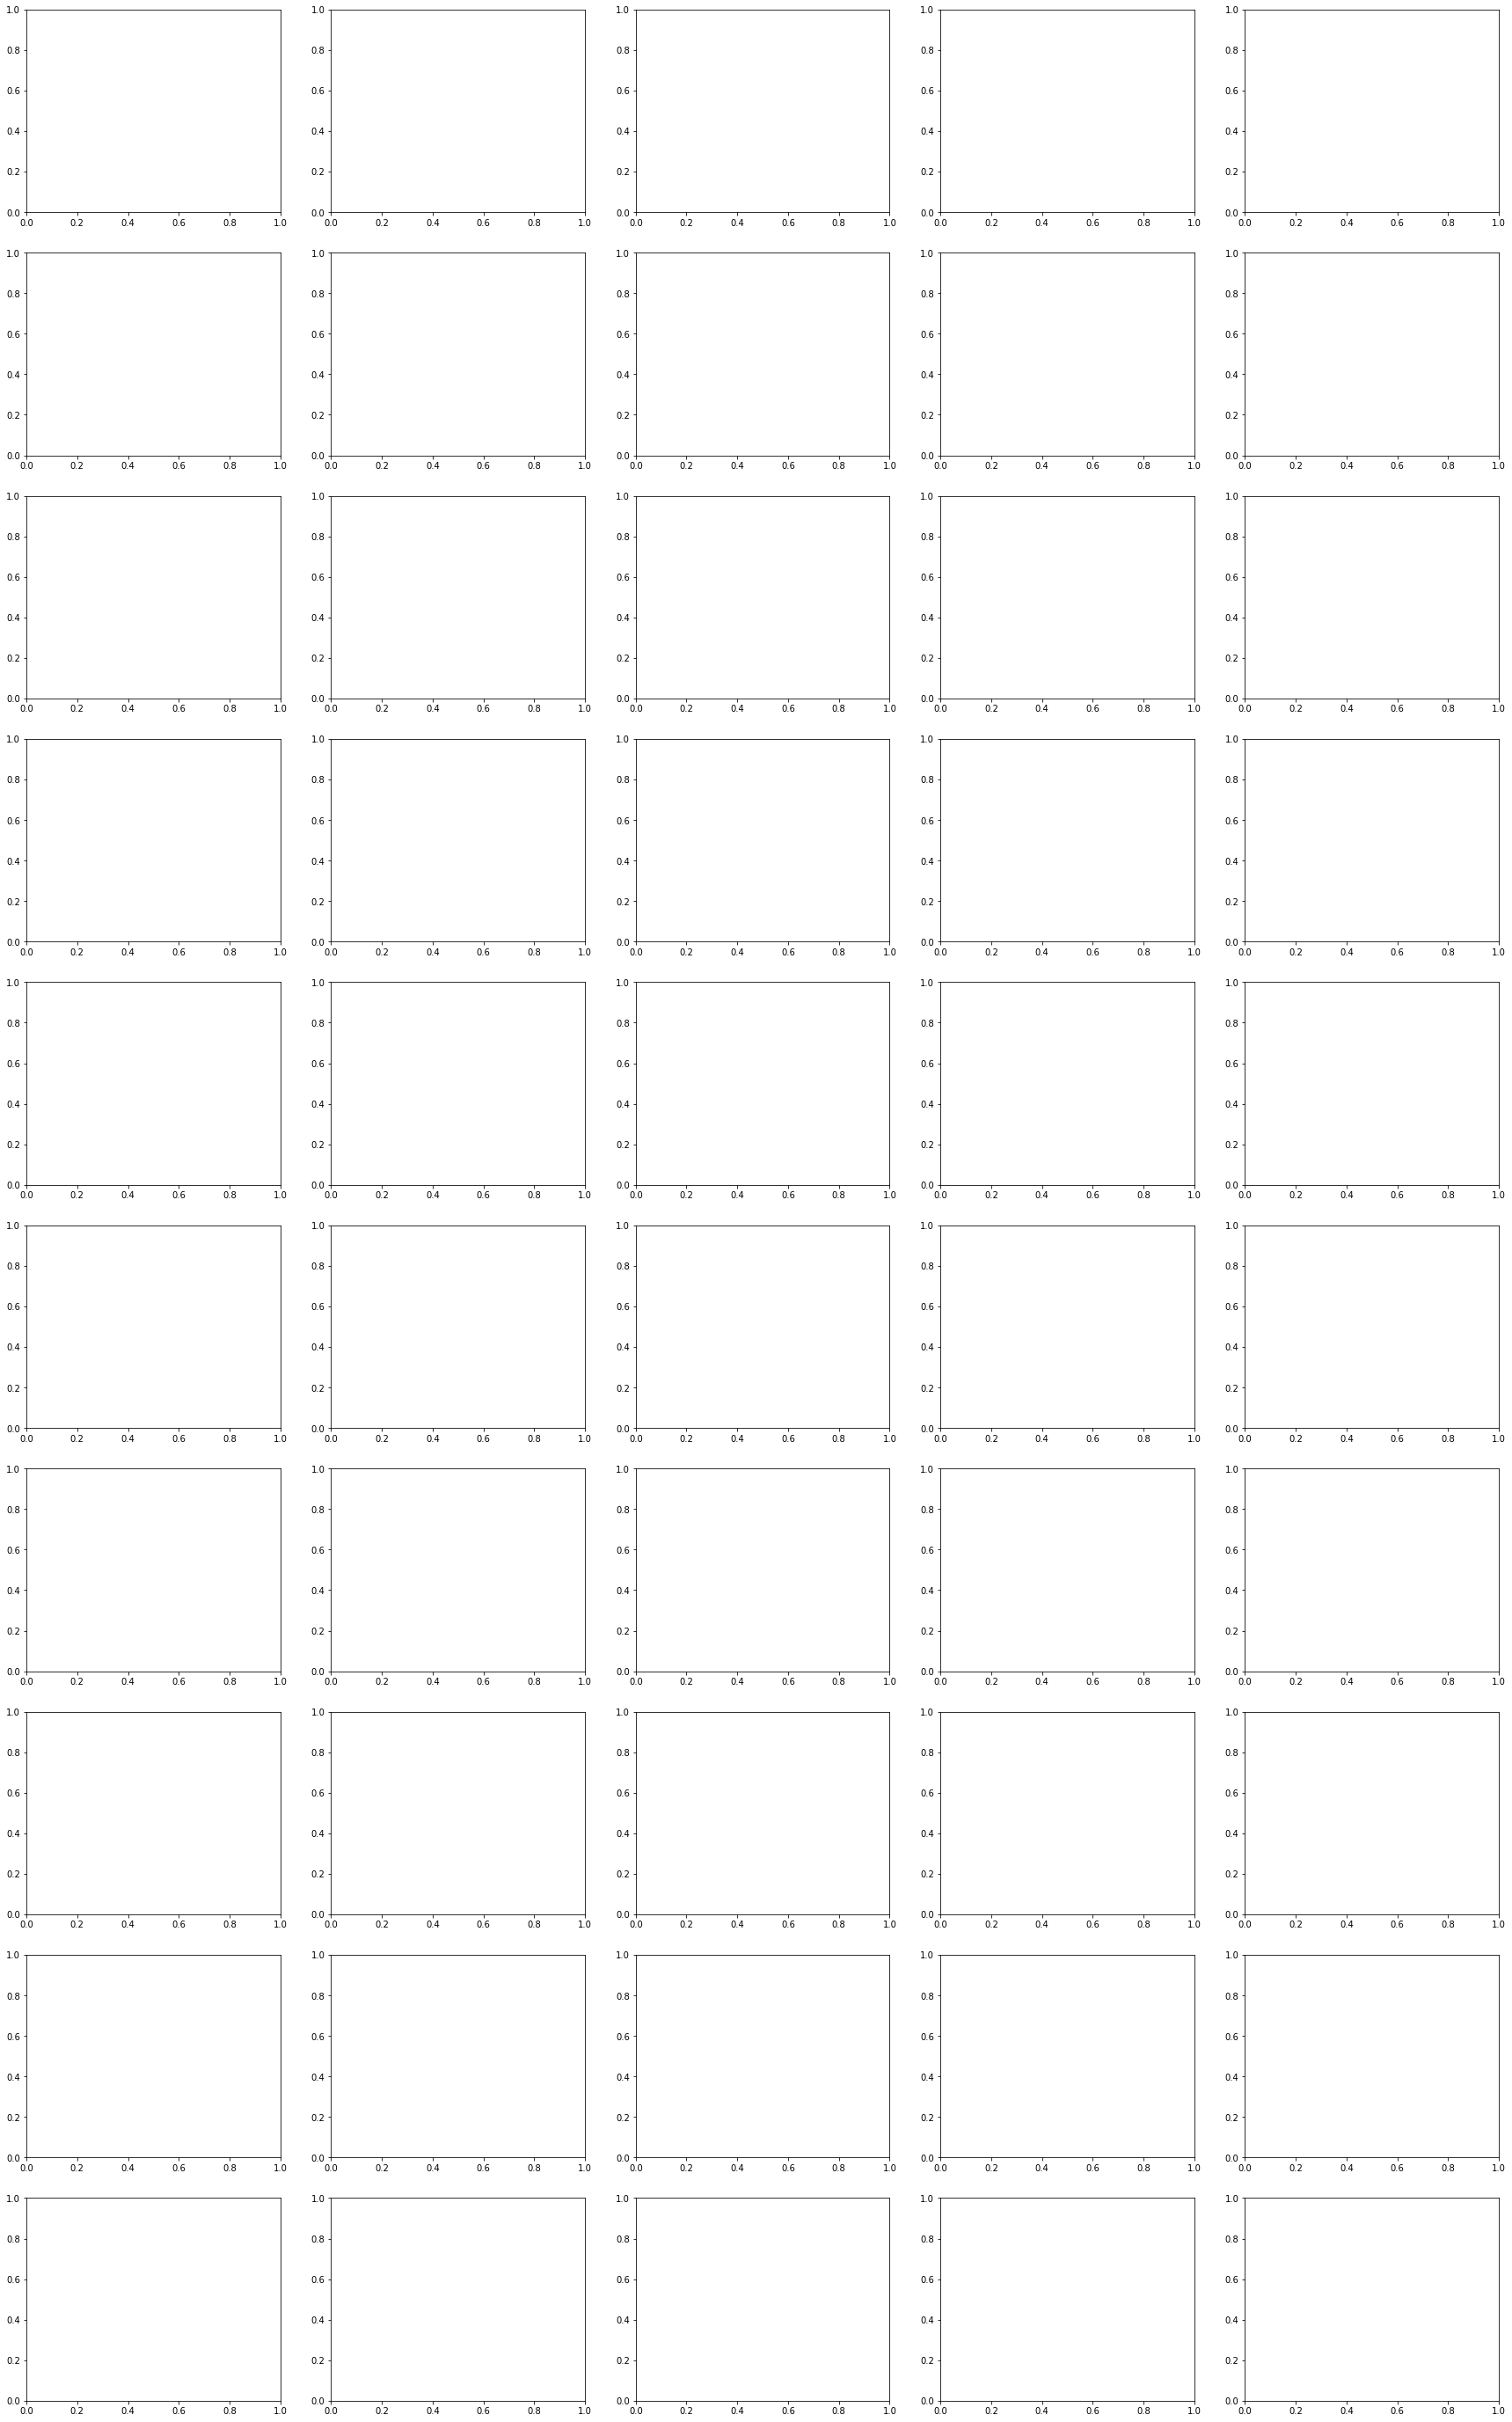

In [176]:
count = 0 
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # read the images and convert them to RGB format
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtain the mask for the image 
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Original Mask")
    axs[count][1].imshow(mask)

    # Obtain the predicted mask for the image 
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("AI Predicted Mask")
    axs[count][2].imshow(predicted_mask)
    
    # Apply the mask to the image 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI with Original Mask (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI with AI Predicted Mask")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()